In [ ]:
#pip install matplotlib
#!pip install scikit-learn #ensures it's installed in the correct env
#pip install -U scikit-learn

In [161]:
#imports only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from scipy import stats
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats


In [167]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)

#Split the binary columns into zeroes and ones and use that going forwards
data = pd.get_dummies(data, columns=["building","noise", "in_vehicle", "asleep","no_windows" ])
data_copy = data.copy()

data.head()

,near_fid,near_x,near_y,near_angle,heard,xcoor,ycoor,age,building_0,building_1,noise_0,noise_1,in_vehicle_0,in_vehicle_1,asleep_0,asleep_1,no_windows_0,no_windows_1
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,1999193.0,9011824,59,1,0,1,0,1,0,1,0,1,0
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,1928298.0,8955382,29,1,0,1,0,1,0,1,0,1,0
2,297,2.026384e+06,8.256164e+06,39.018754,1,2025706.0,8255615,32,1,0,1,0,1,0,1,0,1,0
3,739,1.743184e+06,8.052652e+06,15.046022,1,1742935.0,8052585,36,1,0,1,0,1,0,1,0,1,0
4,1852,1.350375e+06,7.909850e+06,144.603170,1,1350807.0,7909543,55,1,0,1,0,1,0,1,0,1,0


In [168]:
data.describe()

,near_fid,near_x,near_y,near_angle,heard,xcoor,ycoor,age,building_0,building_1,noise_0,noise_1,in_vehicle_0,in_vehicle_1,asleep_0,asleep_1,no_windows_0,no_windows_1
count,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000
mean,1888.705954,1.797385e+06,8.283496e+06,1.751993,0.760070,1.796497e+06,8.283723e+06,50.635902,0.751313,0.248687,0.809107,0.190893,0.905954,0.094046,0.993870,0.006130,0.976357,0.023643
std,1320.046217,2.783430e+05,5.363099e+05,106.216736,0.427078,2.789790e+05,5.369782e+05,18.630865,0.432290,0.432290,0.393039,0.393039,0.291918,0.291918,0.078058,0.078058,0.151947,0.151947
min,1.000000,1.244070e+06,7.430582e+06,-179.786267,0.000000,1.244893e+06,7.432236e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,538.000000,1.535191e+06,7.919606e+06,-90.278514,1.000000,1.529848e+06,7.919276e+06,35.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,1901.000000,1.895376e+06,8.251327e+06,2.313685,1.000000,1.891302e+06,8.251345e+06,50.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2821.000000,2.003408e+06,8.368423e+06,95.330994,1.000000,2.003743e+06,8.368852e+06,66.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,4150.000000,2.686771e+06,1.040622e+07,179.992043,1.000000,2.686256e+06,1.042743e+07,88.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [169]:
#checking correlations

corr_matrix = data.corr()
corr_matrix["heard"].sort_values(ascending=False)

#we can probably group noise and in_vehicle

heard           1.000000
in_vehicle_0    0.406263
noise_0         0.400162
no_windows_0    0.239178
asleep_0        0.139777
building_1      0.063283
near_angle      0.006788
xcoor           0.002301
near_x         -0.003943
building_0     -0.063283
near_fid       -0.120875
near_y         -0.121353
ycoor          -0.121918
asleep_1       -0.139777
no_windows_1   -0.239178
age            -0.288908
noise_1        -0.400162
in_vehicle_1   -0.406263
Name: heard, dtype: float64

In [131]:
#random sampling
def split_train_test(data, test_ratio): 
    shuffled_indices = np.random.permutation(len(data)) #creates array of indices that are randomly shuffled
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#stratified sampling, where we create a sample that takes the distribution of age into account
def stratified_sampling(data, test_ratio, important_data_column):
    split = StratifiedShuffleSplit(n_splits=1, test_size = test_ratio, random_state=42)
    for train_index, test_index in split.split(data, important_data_column):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return strat_train_set, strat_test_set


#create samples
train_set, test_set = stratified_sampling(data, 0.2, data["age"])
#print(len(test_set))
#print(len(train_set))

In [139]:
#compare performances, stratified sampling is better for age group

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def split_comparison(data, target_column, test_size=0.2, random_state=None):
    # Original data overall performance
    overall_performance = data[target_column].value_counts(normalize=True)
    
    # Stratified Sampling
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, data[target_column]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    
    # Random Sampling
    rand_train_set, rand_test_set = train_test_split(data, test_size=test_size, random_state=random_state)
    
    # Calculate performance metrics for stratified sampling
    strat_train_performance = strat_train_set[target_column].value_counts(normalize=True)
    strat_test_performance = strat_test_set[target_column].value_counts(normalize=True)
    
    # Calculate performance metrics for random sampling
    rand_train_performance = rand_train_set[target_column].value_counts(normalize=True)
    rand_test_performance = rand_test_set[target_column].value_counts(normalize=True)
    
    # Calculate percentage error
    strat_train_error = ((strat_train_performance - overall_performance) / overall_performance) * 100
    strat_test_error = ((strat_test_performance - overall_performance) / overall_performance) * 100
    
    rand_train_error = ((rand_train_performance - overall_performance) / overall_performance) * 100
    rand_test_error = ((rand_test_performance - overall_performance) / overall_performance) * 100
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Overall performance': overall_performance,
        'Stratified': strat_test_performance,
        'Random': rand_test_performance,
        'Strat. % error': strat_test_error,
        'Rand. % error': rand_test_error
    })
    
    return comparison_df

# Example usage:
comparison_table = split_comparison(data, target_column='age', test_size=0.2, random_state=42)
print(comparison_table)


    Overall performance  Stratified    Random  Strat. % error  Rand. % error
18             0.011033    0.011384  0.017513        3.174603      58.730159
19             0.012434    0.012259  0.014011       -1.408451      12.676056
20             0.012434    0.012259  0.008757       -1.408451     -29.577465
21             0.015762    0.015762  0.017513        0.000000      11.111111
22             0.012960    0.013135  0.014886        1.351351      14.864865
..                  ...         ...       ...             ...            ...
84             0.002977    0.002627  0.004378      -11.764706      47.058824
85             0.005429    0.005254  0.004378       -3.225806     -19.354839
86             0.003853    0.003503  0.004378       -9.090909      13.636364
87             0.003678    0.003503  0.003503       -4.761905      -4.761905
88             0.002977    0.002627  0.001751      -11.764706     -41.176471

[71 rows x 5 columns]


In [132]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)

# Add distance groups
# Create bins for distance ranging from 0 to 3000 with a step size of 100
distance_bins = np.arange(0, 3100, 100)

# Create labels for distance bins
distance_labels = [f'{i}-{i+100}' for i in range(0, 3000, 100)]
# Append a bin edge for values greater than 3000
distance_bins = np.append(distance_bins, np.inf)
distance_labels.append('>3000')

# Assign each distance value to a corresponding bin
data['distance_groups'] = pd.cut(data['dist'], bins=distance_bins, labels=distance_labels, right=False)
    

In [134]:
#create age groups
from pandas.plotting import scatter_matrix
import seaborn as sns

print(data.columns)
binary_attributes = ['heard', 'building', 'noise', 'in_vehicle', 'asleep', 'no_windows']

#Comparing age and heard
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create age groups column
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'heard', 'building',
       'xcoor', 'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'age',
       'dist', 'distance_groups', 'age_group'],
      dtype='object')


# (i) Does the distance to the nearest horn affect whether a person hears the siren or not?

In [135]:


for distance in data["distance_groups"].unique():
    #print("distance: ", type(distance))
    #print("distance: ", distance)
    if ">" not in distance:
        firstValue, secondValue = distance.split("-")
        #print(firstValue)
    elif ">" in distance:
        firstValue, secondValue = distance.split(">")
        #print(secondValue)
    else:
        print("Problem")

# (ii) Are the people who hear the siren younger than the people who do not hear it?

Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'heard', 'building',
       'xcoor', 'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'age',
       'dist', 'distance_groups', 'age_group'],
      dtype='object')


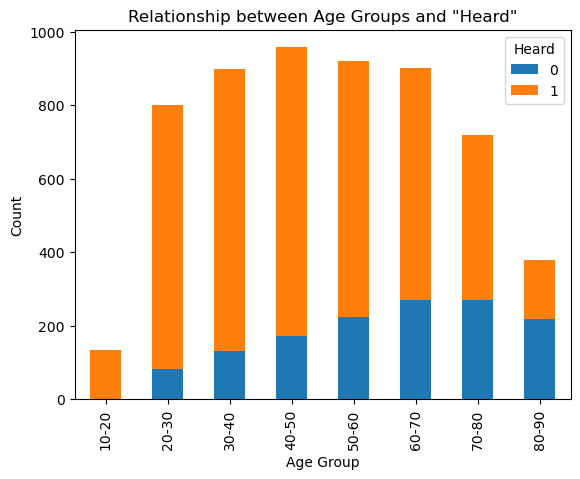

In [143]:
from pandas.plotting import scatter_matrix
import seaborn as sns


print(data.columns)
binary_attributes = ['heard', 'building', 'noise', 'in_vehicle', 'asleep', 'no_windows']

#Comparing age and heard
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create age groups column
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

# Create stacked bar chart
pd.crosstab(data['age_group'], data['heard']).plot.bar(stacked=True)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Relationship between Age Groups and "Heard"')
plt.legend(title='Heard')
plt.show()

Text(0, 0.5, 'The procent hearing (%)')

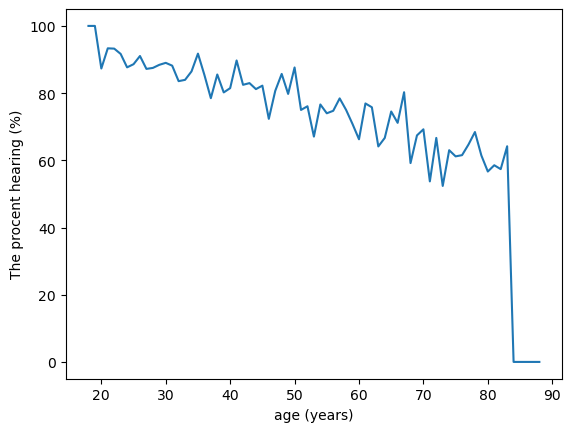

In [170]:
#The relationship between age and hearing
age_num = data_copy.pivot_table(index = ['age'], columns= 'heard', aggfunc='size')

age_num[1] = age_num[1].fillna(0)
age_num[0] = age_num[0].fillna(0)
age_num_1 = np.array(age_num[1])
age_num_0 = np.array(age_num[0])

age_procent = (age_num_1)/(age_num_1+age_num_0)*100 #procent som hör per åldersgrupp

index_age = np.array(age_num.index)

plt.plot(index_age, age_procent)
plt.xlabel('age (years)')
plt.ylabel('The procent hearing (%)')



Text(0, 0.5, 'The procent hearing (%)')

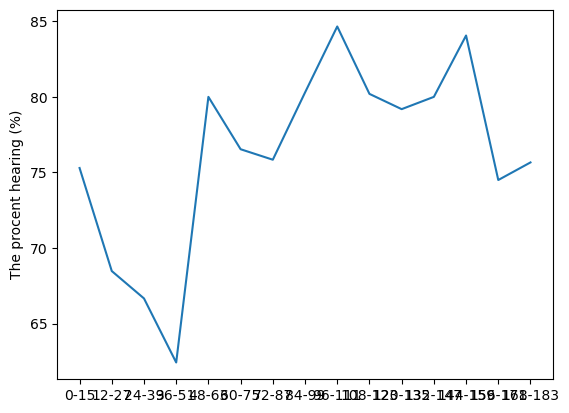

In [152]:
# Create bins for angle ranging from 0 to 2000 with a step size of 100
angle_bins = np.arange(0, 181, 12)

# Create labels for angle bins
angle_labels = [f'{i}-{i+15}' for i in range(0, 180, 12)]

# Assign each angle value to a corresponding bin
data['ange_span'] = pd.cut(data['near_angle'], bins=angle_bins, labels=angle_labels, right=False)

angle_num = data.pivot_table(index = ['ange_span'], columns= 'heard', aggfunc='size')

angle_num_1 = np.array(angle_num[1])
angle_num_0 = np.array(angle_num[0])

angle_procent = (angle_num_1 )/(angle_num_1 +angle_num_0)*100 #procent som hör

index_angle = np.array(angle_num.index)

plt.plot(index_angle, angle_procent)
plt.xlabel('')
plt.ylabel('The procent hearing (%)')


In [153]:
#Prepering the data for training and validation

data['dist'] = np.sqrt((data.near_x - data.xcoor)**2 + (data.near_y - data.ycoor)**2)

feat = ['near_fid', 'near_x', 'near_y', 'near_angle', 'xcoor', 'ycoor',
       'age', 'building_0', 'building_1', 'noise_0', 'noise_1', 'in_vehicle_0',
       'in_vehicle_1', 'asleep_0', 'asleep_1', 'no_windows_0', 'no_windows_1', 'dist']

x = data[feat] #inputs

y = data.heard # output

x = data[feat] #inputs

y = data['heard'] # output 
train_X, val_X, train_y, val_y = train_test_split(x,y, random_state=0, train_size=0.8)

In [154]:
model_tree = RandomForestClassifier()

par = {'n_estimators': stats.randint(50, 750), 'criterion':['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9], 'min_samples_split' : [1,2,3,4, 5, 6]}


RSC = RandomizedSearchCV(model_tree, param_distributions = par, n_iter = 10, cv=5, n_jobs = -1 )

RSC.fit(train_X, train_y)

model_tree = RSC.best_estimator_

model_tree.fit(train_X, train_y)

model_tree_prediction = model_tree.predict(val_X)

print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/joblib/parallel.py", line 1048, in __call__

heard    0    1
row_0          
0      191   22
1       61  868
acc: 0.9273204903677759


In [155]:
print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

heard    0    1
row_0          
0      191   22
1       61  868
acc: 0.9273204903677759


# Other


In [164]:
# for each age group
# count number of heard of the total age group size
# store in a new array

data['distance_groups'] = data['distance_groups'].astype(str)
distance_heard_percentage = []
distance_group_array = []

#Behöver nog ändra distance_groups till ints istället, för blir whack när vi sorterar på sträng, 
#1000 kommer efter 100, men 200 bör komma efter 100

for distance in sorted(data["distance_groups"].unique()): 
    subset_data = data.loc[data['distance_groups'] == distance]
    heard_count = (subset_data['heard'] == 1).sum()
    total_count = len(subset_data)
    percentage_heard_per_distance = heard_count/total_count
    distance_group_array.append(distance)
    distance_heard_percentage.append(percentage_heard_per_distance)
    

#print(distance_group_array)
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(distance_group_array, distance_heard_percentage, color='skyblue')
plt.xlabel('Distance Groups')
plt.ylabel('% Heard')
plt.title('Percentage Heard Based on Distance Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines to y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
#plt.show()

custom_ticks = [i/10 for i in range(11)]  # Custom ticks from 0 to 1 with step size 0.1
plt.yticks(custom_ticks, [f"{tick:.1f}" for tick in custom_ticks])

plt.grid(axis='y')  # Add gridlines to y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

KeyError: 'distance_groups'